In [148]:
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import plotly.graph_objects as go
from torch.distributions import Dirichlet
from torch.distributions.kl import _kl_dirichlet_dirichlet
import scipy.stats as stats
%matplotlib inline

In [58]:
# create synthetic data set
# analogous to original synthetic dataset. See:
# https://github.com/KaosEngineer/PriorNetworks-OLD/blob/master/prior_networks/dirichlet/dirichlet_prior_network_synth.py#L73


Create a synthetic dataset of 500 points which corresponds to 3 gaussians.

In [59]:

num_points = 500
# ensure num_points is divisible by 3
num_points = 3 * (num_points // 3)
mixture_proportions = [1 / 3.0, 1 / 3.0, 1 / 3.0]
scale = 10.0
mu = [
    scale * np.asarray([0, 1.0], dtype=np.float32),
    scale * np.asarray([-np.sqrt(3) / 2, -1. / 2], dtype=np.float32),
    scale * np.asarray([np.sqrt(3) / 2, -1. / 2], dtype=np.float32)
]
diag_cov = 2 * np.identity(2)

In [60]:
# create dataset

samples, labels = [], []
for i in range(len(mu)):
    num_class_samples = int(num_points*mixture_proportions[i])
    class_samples = np.random.multivariate_normal(
        mean=mu[i],
        cov=diag_cov,
        size=num_class_samples)
    samples.append(class_samples)
    class_labels = np.full(
        shape=num_class_samples,
        fill_value=i)
    labels.append(class_labels)
samples = np.concatenate(samples)
labels = np.concatenate(labels)

In [61]:
# shuffle dataset

shuffle_idx = np.random.choice(
    np.arange(num_points),
    size=num_points,
    replace=False)
samples = samples[shuffle_idx, :]
labels = labels[shuffle_idx]

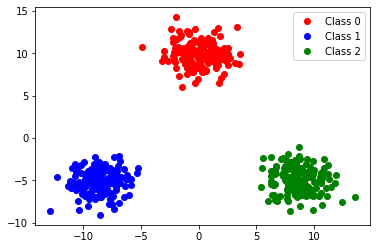

In [62]:
plt.plot(samples[labels==0][:,0], samples[labels==0][:,1], 'ro', label='Class 0')
plt.plot(samples[labels==1][:,0], samples[labels==1][:,1], 'bo', label='Class 1')
plt.plot(samples[labels==2][:,0], samples[labels==2][:,1], 'go', label='Class 2')
plt.legend()
plt.show()

In [88]:
# set concentration parameter
alpha_0 = 3.0

In [64]:

# helper function for checking that no element is NaN or Inf
def assert_no_nan_no_inf(x):
    assert not torch.isnan(x).any()
    assert not torch.isinf(x).any()

# Logistic Regression by MLE

First we will train a logistic regression model by maximizing likelihood.

In [99]:
# instantiate classification model
class Network(nn.Module):
    def __init__(self,
                 alpha_0=3.):
        super().__init__()
        self.alpha_0 = alpha_0
        self.weights = nn.Linear(
            in_features=2,
            out_features=3)

    def forward(self, x):
        alphas = self.weights(x)
        assert_no_nan_no_inf(alphas)
        output = F.softmax(alphas / self.alpha_0, dim=1)
        assert_no_nan_no_inf(output)
        return output

#logistic regression net    
lr_net = Network(alpha_0=alpha_0)

In [100]:
# define typical classification function
criterion = nn.NLLLoss()

In [67]:
# convert data from numpy arrays to tensors
samples = torch.Tensor(samples)
labels = torch.Tensor(labels).to(torch.int64)

In [101]:
# prepare to train
optimizer = optim.SGD(lr_net.parameters(), lr=0.01)
num_training_steps = 100
batch_size = 20

# train!
losses = []
for step in range(num_training_steps):
    optimizer.zero_grad()   # zero the gradient buffers
    batch_idx = np.random.choice(
        np.arange(num_points),
        size=batch_size,
        replace=False)
    batch_samples, batch_labels = samples[batch_idx], labels[batch_idx]
    pred_labels = lr_net(batch_samples)
    loss = criterion(pred_labels, batch_labels)
    print('Step: {}, Loss: {}'.format(step, loss.item()))
    losses.append(loss.item())
    loss.backward()
    optimizer.step()


Step: 0, Loss: -0.09748077392578125
Step: 1, Loss: -0.07277123630046844
Step: 2, Loss: -0.08409864455461502
Step: 3, Loss: -0.09399767220020294
Step: 4, Loss: -0.0821058377623558
Step: 5, Loss: -0.08143710345029831
Step: 6, Loss: -0.08623577654361725
Step: 7, Loss: -0.0911731868982315
Step: 8, Loss: -0.09424708783626556
Step: 9, Loss: -0.07498057931661606
Step: 10, Loss: -0.09541120380163193
Step: 11, Loss: -0.07593477517366409
Step: 12, Loss: -0.09402924031019211
Step: 13, Loss: -0.07044932246208191
Step: 14, Loss: -0.08622126281261444
Step: 15, Loss: -0.08076034486293793
Step: 16, Loss: -0.08139064908027649
Step: 17, Loss: -0.09542243182659149
Step: 18, Loss: -0.08298654854297638
Step: 19, Loss: -0.08225761353969574
Step: 20, Loss: -0.08959874510765076
Step: 21, Loss: -0.08474251627922058
Step: 22, Loss: -0.0765475332736969
Step: 23, Loss: -0.07166223973035812
Step: 24, Loss: -0.11005613952875137
Step: 25, Loss: -0.06646525859832764
Step: 26, Loss: -0.0876082107424736
Step: 27, Loss:

In [102]:
lr_preds = lr_net.forward(samples)
lr_preds

tensor([[0.0274, 0.6575, 0.3151],
        [0.4715, 0.1951, 0.3334],
        [0.0538, 0.5956, 0.3506],
        ...,
        [0.8606, 0.0520, 0.0874],
        [0.5024, 0.1852, 0.3124],
        [0.2571, 0.3263, 0.4166]], grad_fn=<SoftmaxBackward>)

In [103]:
# plot training loss
plot_data = [
    go.Scatter(
        x=np.arange(len(losses)),
        y=losses,
        mode='lines')
]

layout = dict(
    title='Negative Log Likelihood Per Batch',
    yaxis=dict(title='NLL'),
    xaxis=dict(title='Batch (size={})'.format(batch_size))
)
fig = go.Figure(data=plot_data, layout=layout)
fig.show()


# Logistic Regression via Prior Network methodology

We will first train the logistic regression model using the prior network methodology by minimizing the forward KL divergence.

In [212]:
# now, we transition towards trying the prior networks approach.
# we will first attempt to train using the left term of Equation 12

# define softened labels
one_hot_labels = F.one_hot(labels).to(torch.float32)
epsilon = 0.01
soft_labels = one_hot_labels - one_hot_labels * len(mu) * epsilon + epsilon
soft_concentrations = alpha_0 * soft_labels

In [213]:
soft_concentrations.shape

torch.Size([498, 3])

In [215]:
soft_labels.shape

torch.Size([498, 3])

In [106]:
# define loss function
# first term of equation 12. See
# https://github.com/KaosEngineer/PriorNetworks-OLD/blob/master/prior_networks/dirichlet/dirichlet_prior_network_synth.py#L107

def eqn_twelve_forward(model_softmax_outputs, target_concentrations):
    target_dirichlet = Dirichlet(target_concentrations)
    model_dirichlet = Dirichlet(model_softmax_outputs)
    kl_divs = _kl_dirichlet_dirichlet(p=target_dirichlet, q=model_dirichlet)
    assert_no_nan_no_inf(kl_divs)
    mean_kl = torch.mean(kl_divs)
    return mean_kl

In [107]:
# create new network
pn_forward_net = Network(alpha_0=alpha_0)
optimizer = optim.SGD(pn_forward_net.parameters(), lr=0.01)


# train!
losses, grad_norms = [], []
for step in range(num_training_steps):
    optimizer.zero_grad()   # zero the gradient buffers
    batch_idx = np.random.choice(
        np.arange(num_points),
        size=batch_size,
        replace=False)
    batch_samples = samples[batch_idx]
    batch_concentrations = soft_concentrations[batch_idx]
    pred_labels = pn_forward_net(batch_samples)
    loss = eqn_twelve_forward(
        model_softmax_outputs=pred_labels,
        target_concentrations=batch_concentrations)
    print('Step: {}, Loss: {}'.format(step, loss.item()))
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

Step: 0, Loss: 17.7061767578125
Step: 1, Loss: 10.016121864318848
Step: 2, Loss: 8.800432205200195
Step: 3, Loss: 3.718099594116211
Step: 4, Loss: 2.329742908477783
Step: 5, Loss: 1.1033433675765991
Step: 6, Loss: 1.159627914428711
Step: 7, Loss: 0.8627325296401978
Step: 8, Loss: 0.580398440361023
Step: 9, Loss: 0.6018229126930237
Step: 10, Loss: 0.5122735500335693
Step: 11, Loss: 0.43704286217689514
Step: 12, Loss: 0.41188955307006836
Step: 13, Loss: 0.2760729193687439
Step: 14, Loss: 0.38733425736427307
Step: 15, Loss: 0.393149733543396
Step: 16, Loss: 0.4998932480812073
Step: 17, Loss: 0.4875829815864563
Step: 18, Loss: 0.38744550943374634
Step: 19, Loss: 0.27452465891838074
Step: 20, Loss: 0.32463741302490234
Step: 21, Loss: 0.4465484619140625
Step: 22, Loss: 0.357949435710907
Step: 23, Loss: 0.3748215138912201
Step: 24, Loss: 0.4102489948272705
Step: 25, Loss: 0.380035400390625
Step: 26, Loss: 0.3438263535499573
Step: 27, Loss: 0.29479360580444336
Step: 28, Loss: 0.413335323333740

In [108]:
pn_forward_net.forward(samples)

tensor([[0.9546, 0.0233, 0.0221],
        [0.0160, 0.0222, 0.9618],
        [0.8907, 0.0509, 0.0585],
        ...,
        [0.0250, 0.9473, 0.0277],
        [0.0231, 0.0400, 0.9368],
        [0.0634, 0.0251, 0.9115]], grad_fn=<SoftmaxBackward>)

In [109]:
# plot training loss

plot_data = [
    go.Scatter(
        x=np.arange(len(losses)),
        y=losses,
        mode='lines')
]

layout = dict(
    title='Eqn 12 Term 1 Loss Per Batch',
    yaxis=dict(title='Loss'),
    xaxis=dict(title='Batch (size={})'.format(batch_size))
)
fig = go.Figure(data=plot_data, layout=layout)
fig.show()

## Adding Out-of-distribution Samples

In [216]:
# add out of distribution points to our dataset
num_points = 498
num_additional_points = 100
num_points += num_additional_points
out_of_dist_samples = torch.tensor(
    np.random.normal(-50, 10, size=(num_additional_points, 2))).to(torch.float32)
out_of_dist_concentrations = torch.tensor(
    np.ones(shape=(num_additional_points, 3))).to(torch.float32)
samples1 = torch.cat((samples, out_of_dist_samples))
soft_labels1 = torch.cat((soft_labels, out_of_dist_concentrations/alpha_0))
soft_concentrations1 = torch.cat((soft_concentrations, out_of_dist_concentrations))

In [218]:
samples1.shape

torch.Size([598, 2])

In [219]:
soft_labels1.shape

torch.Size([598, 3])

In [235]:
soft_concentrations1

tensor([[2.9400, 0.0300, 0.0300],
        [0.0300, 0.0300, 2.9400],
        [2.9400, 0.0300, 0.0300],
        ...,
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000]])

In [220]:
soft_concentrations1.shape

torch.Size([598, 3])

In [222]:
num_points

598

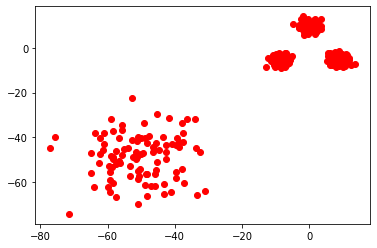

In [221]:
plt.plot(samples1[:,0], samples1[:,1], 'ro')
plt.show()

In [223]:
# create new network
pn_forward_net_out = Network(alpha_0=alpha_0)
optimizer = optim.SGD(pn_forward_net_out.parameters(), lr=0.01)

num_training_steps = 100


# train!
losses, grad_norms = [], []
for step in range(num_training_steps):
    optimizer.zero_grad()   # zero the gradient buffers
    batch_idx = np.random.choice(
        np.arange(num_points),
        size=batch_size,
        replace=False)
    batch_samples = samples1[batch_idx]
    batch_concentrations = soft_concentrations1[batch_idx]
    pred_labels = pn_forward_net_out.forward(batch_samples)
    loss = eqn_twelve_forward(
        model_softmax_outputs=pred_labels,
        target_concentrations=batch_concentrations)
    print('Step: {}, Loss: {}'.format(step, loss.item()))
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

Step: 0, Loss: 22.141584396362305
Step: 1, Loss: 22.85553550720215
Step: 2, Loss: 17.167139053344727
Step: 3, Loss: 14.605195999145508
Step: 4, Loss: 12.016942977905273
Step: 5, Loss: 13.897970199584961
Step: 6, Loss: 12.542451858520508
Step: 7, Loss: 9.743099212646484
Step: 8, Loss: 7.2958221435546875
Step: 9, Loss: 4.891394138336182
Step: 10, Loss: 4.642034530639648
Step: 11, Loss: 9.666078567504883
Step: 12, Loss: 4.617108345031738
Step: 13, Loss: 3.294553756713867
Step: 14, Loss: 5.348977088928223
Step: 15, Loss: 8.244547843933105
Step: 16, Loss: 3.0321834087371826
Step: 17, Loss: 5.606407165527344
Step: 18, Loss: 1.9230804443359375
Step: 19, Loss: 8.618525505065918
Step: 20, Loss: 5.646042823791504
Step: 21, Loss: 4.664776802062988
Step: 22, Loss: 6.000368118286133
Step: 23, Loss: 4.801662445068359
Step: 24, Loss: 5.095302581787109
Step: 25, Loss: 4.609429836273193
Step: 26, Loss: 3.6568093299865723
Step: 27, Loss: 4.873556613922119
Step: 28, Loss: 3.906337022781372
Step: 29, Loss

In [224]:
# plot training loss

plot_data = [
    go.Scatter(
        x=np.arange(len(losses)),
        y=losses,
        mode='lines')
]

layout = dict(
    title='Eqn 12 Term 1 Loss Per Batch',
    yaxis=dict(title='Loss'),
    xaxis=dict(title='Batch (size={})'.format(batch_size))
)
fig = go.Figure(data=plot_data, layout=layout)
fig.show()

In [225]:
PN_preds_out = pn_forward_net_out.forward(samples1)

In [226]:
PN_preds_out.shape

torch.Size([598, 3])

In [227]:
PN_preds_out.detach().numpy()

array([[8.8663828e-01, 1.0433372e-01, 9.0279356e-03],
       [9.5709655e-03, 3.5240050e-02, 9.5518899e-01],
       [8.0791575e-01, 1.6432290e-01, 2.7761381e-02],
       ...,
       [9.6635980e-05, 9.7570091e-01, 2.4202386e-02],
       [6.4434418e-05, 9.9731016e-01, 2.6253590e-03],
       [3.4130906e-05, 9.7678816e-01, 2.3177719e-02]], dtype=float32)

In [228]:
PN_preds_out = PN_preds_out.detach().numpy()


In [229]:
PN_preds_out[498:]

array([[4.52665120e-07, 7.19735026e-02, 9.28026021e-01],
       [5.06048764e-07, 4.72884357e-01, 5.27115166e-01],
       [1.17251126e-03, 8.38290572e-01, 1.60536870e-01],
       [9.79317047e-05, 5.84736824e-01, 4.15165186e-01],
       [3.07210808e-04, 7.71754384e-01, 2.27938458e-01],
       [2.41093789e-04, 9.75869119e-01, 2.38898080e-02],
       [2.76060600e-04, 9.82819021e-01, 1.69049092e-02],
       [4.55770969e-05, 9.83990431e-01, 1.59638822e-02],
       [7.59507166e-05, 6.16527677e-01, 3.83396417e-01],
       [4.49426203e-08, 2.74947640e-02, 9.72505212e-01],
       [5.49886954e-06, 4.14110363e-01, 5.85884213e-01],
       [1.88512928e-07, 8.43212783e-01, 1.56787008e-01],
       [4.16317363e-07, 1.41554400e-01, 8.58445168e-01],
       [5.18047018e-04, 9.96669114e-01, 2.81287404e-03],
       [8.41819856e-04, 9.97418523e-01, 1.73961825e-03],
       [1.67185572e-05, 9.54508662e-01, 4.54745665e-02],
       [3.94197514e-06, 4.55724478e-01, 5.44271529e-01],
       [2.23266488e-05, 9.43775

In [230]:
#helper to calculate mean entropy
def calc_mean_entropy(preds):
    entropies = []
    for i in range(preds.shape[0]):
        entropies.append(stats.entropy(preds[i]))
    return np.array(entropies).mean()
        

In [231]:
#calculate the entropy for in distribution
in_dist_entropy = calc_mean_entropy(PN_preds_out[:498])
in_dist_entropy

0.55558306

In [232]:
out_dist_entropy = calc_mean_entropy(PN_preds_out[498:])
out_dist_entropy

0.30398744